# Packages and settings 
We start by defining packages and some basic settings (matplotlib style, parameters, ...)


In [1]:
#%config IPCompleter.greedy=True

# Packages
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
import dill
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_validate, RepeatedKFold, learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgbm

# Plot options
%matplotlib notebook
sns.set(style="whitegrid")

# Parameter
dataloc = "../data/"
plotloc = "../output/"

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In case several functions need to be defined this should be put into an *init* file. For now we define them directly

In [2]:
# Initialize
#import os; os.getcwd(); os.chdir("C:/Users/Uwe/Desktop/python") #need to set working dir?
#exec(open("../code/0_init.py").read())

def setdiff(a, b):
    return [x for x in a if x not in set(b)]

# 1. ETL
We need to do some ETL (extract, transform, load)

In [3]:
# Read data
df_orig = pd.read_csv(dataloc + "titanic.csv")
df_orig

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1st,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.549999,E12,Southampton,3,NaN,"New York, NY"
6,1st,1,"Andrews, Miss. Kornelia Theodos",female,63.0000,1,0,13502,77.958298,D7,Southampton,10,NaN,"Hudson, NY"
7,1st,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.000000,A36,Southampton,NaN,NaN,"Belfast, NI"
8,1st,1,"Appleton, Mrs. Edward Dale (Cha",female,53.0000,2,0,11769,51.479198,C101,Southampton,D,NaN,"Bayside, Queens, NY"
9,1st,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.504200,NaN,Cherbourg,NaN,22.0,"Montevideo, Uruguay"


## 1.1 Quick check

Lets check the numeric columns

In [4]:
df_orig.survived

,survived,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.486055,14.413500,1.041658,0.865560,51.758669,97.696922
min,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,1.000000,80.000000,8.000000,9.000000,512.329224,328.000000


  Dito for categegorical columns

In [7]:
df_orig.describe(include = ["object"])


,pclass,name,sex,ticket,cabin,embarked,boat,home.dest
count,1309,1309,1309,1309,295,1307,486,745
unique,3,1307,2,929,186,3,27,368
top,3rd,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,Southampton,13,"New York, NY"
freq,709,2,843,11,6,914,39,64


Get more details, i.e. Top-4 most frequent members

In [8]:
pd.concat([df_orig[catname].value_counts()[:4].reset_index().rename(columns = {"index": catname, catname: "#"+catname})
                     for catname in df_orig.select_dtypes(["object"]).columns.values], axis = 1).style.bar(color='grey')


,pclass,#pclass,name,#name,sex,#sex,ticket,#ticket,cabin,#cabin,embarked,#embarked,boat,#boat,home.dest,#home.dest
0,3rd,709,"Connolly, Miss. Kate",2,male,843,CA. 2343,11,C23 C25 C27,6,Southampton,914,13,39,"New York, NY",64
1,1st,323,"Kelly, Mr. James",2,female,466,CA 2144,8,G6,5,Cherbourg,270,C,38,London,14
2,2nd,277,"Lockyer, Mr. Edward",1,nan,nan,1601,8,B57 B59 B63 B66,5,Queenstown,123,15,37,"Montreal, PQ",10
3,nan,nan,"Sunderland, Mr. Victor Francis",1,nan,nan,3101295,7,C78,4,nan,nan,14,33,"Paris, France",9


Last check: Distribution of the target

In [9]:
df_orig["survived"].value_counts() / df_orig.shape[0]

0    0.618029
1    0.381971
Name: survived, dtype: float64

"Save" original data

In [10]:
df = df_orig.copy()

## 1.2 Feature engineering

In [11]:
#df$deck = as.factor(str_sub(df$cabin, 1, 1))
df["deck"] = df["cabin"].str[:1]
#summary(df$deck)
df.deck.describe()
df.deck.value_counts()
# also possible: df$familysize = df$sibsp + df$parch as well as something with title from name



C    94
B    65
D    46
E    41
A    22
F    21
G     5
T     1
Name: deck, dtype: int64

## 1.3 Define target and train/test-fold

In [12]:
df["target"] = np.where(df.survived == 0, "N", "Y") 
df["target_num"] = df.target.map({"N":0, "Y":1})

In [13]:
# Train/Test fold: usually split by time
df["fold"] = "train"
df.loc[df.sample(frac = 0.3, random_state = 123).index, "fold"] = "test"
df.fold.value_counts()

train    916
test     393
Name: fold, dtype: int64

<br><br><br><br>

# 2 Metric variables: Explore and adapt

First define the metric covariates in a set

In [16]:
metr = ["age","fare"]
df[metr].describe()

,age,fare
count,1046.000000,1308.000000
mean,29.881135,33.295479
std,14.413500,51.758669
min,0.166700,0.000000
25%,21.000000,7.895800
50%,28.000000,14.454200
75%,39.000000,31.275000
max,80.000000,512.329224


## 2.1 Binning
Additionally (!) create nominal variables for all metric variables by binning in quantiles.  
These variables are used for **Elastic Net** approach and help in modelling non-linear relationships of features with the target.  
The binning must be done before any imputation in order to set the missings to their own "(missing)" bin.

In [19]:
metr_binned = [x + "_BINNED_" for x in metr]
df[metr_binned] = df[metr].apply(lambda x: pd.qcut(x, 10).astype(object))

# Convert missings to own level ("(Missing)")
df[metr_binned] = df[metr_binned].fillna("(missing)")
df[metr_binned].describe()
#{print(df[x].value_counts()[:11]) for x in metr_binned}

,age_BINNED_,fare_BINNED_
count,1309,1309
unique,11,11
top,(missing),"(7.854, 8.05]"
freq,263,146


## 2.2 Missings
Lets investigate missings.

In [26]:
# Get missing ratio
misspct = df[metr].isnull().mean().round(3)
misspct.sort_values(ascending = False)

age     0.201
fare    0.001
dtype: float64

We remove all variables with a missing rate above a threshold (95%). 
Fortunately the threshold is not reached for all  metric variables. 
Anyway, we keep the code for removing as it is implemented in a way that nothing changes in case no variable has to be removed.

In [28]:
# Remove variables with too many missings from metr-set
remove = misspct[misspct > 0.95].index.values.tolist()
print(remove)
metr = setdiff(metr, remove)

[]


In [ ]:
# Create mising indicators
#(miss = metr[map_lgl(df[metr], ~ any(is.na(.)))])
miss = (np.array(metr)[df[metr].isnull().any().values]).tolist()
df[["MISS_" + x for x in miss]] = pd.DataFrame(np.where(df[miss].isnull(), "miss", "no_miss"))
df[["MISS_" + x for x in miss]].describe()

In [14]:
# Impute missings with randomly sampled value (or median, see below)
#df[miss] = map(df[miss], ~ {
#  i.na = which(is.na(.x))
#  .x[i.na] = sample(.x[-i.na], length(i.na) , replace = TRUE)
#  #.x[i.na] = median(.x[-i.na], na.rm = TRUE) #median imputation
#  .x }
#)
df[miss] = df[miss].fillna(df[miss].median())
df[miss].describe()



# Outliers + Skewness --------------------------------------------------------------------------------------------

# Check for outliers and skewness
#plots = get_plot_distr_metr_class(df, metr, missinfo = NULL)
#ggsave(paste0(plotloc, "titanic_distr_metr.pdf"), suppressMessages(marrangeGrob(plots, ncol = 4, nrow = 2)), 
#       width = 18, height = 12)



(missing)        263
(31.0, 36.0]     121
(14.0, 19.0]     118
(22.0, 25.0]     110
(19.0, 22.0]     108
(0.166, 14.0]    107
(42.0, 50.0]     100
(28.0, 31.0]      98
(36.0, 42.0]      96
(50.0, 80.0]      95
(25.0, 28.0]      93
Name: age_BINNED_, dtype: int64
(7.854, 8.05]        146
(7.567, 7.854]       144
(26.955, 41.579]     134
(78.051, 512.329]    131
(-0.001, 7.567]      131
(14.454, 21.679]     130
(41.579, 78.051]     128
(21.679, 26.955]     128
(10.5, 14.454]       128
(8.05, 10.5]         108
(missing)              1
Name: fare_BINNED_, dtype: int64
[]


,age,fare
count,1309.000000,1309.000000
mean,29.503183,33.281086
std,12.905246,51.741500
min,0.166700,0.000000
25%,22.000000,7.895800
50%,28.000000,14.454200
75%,35.000000,31.275000
max,80.000000,512.329224


In [17]:
metr

['age',
 'fare',
 'age',
 'fare',
 'age',
 'fare',
 'age',
 'fare',
 'age',
 'fare',
 'age',
 'fare',
 'age',
 'fare',
 'age',
 'fare',
 'age',
 'fare',
 'age',
 'fare']

<IPython.core.display.Javascript object>


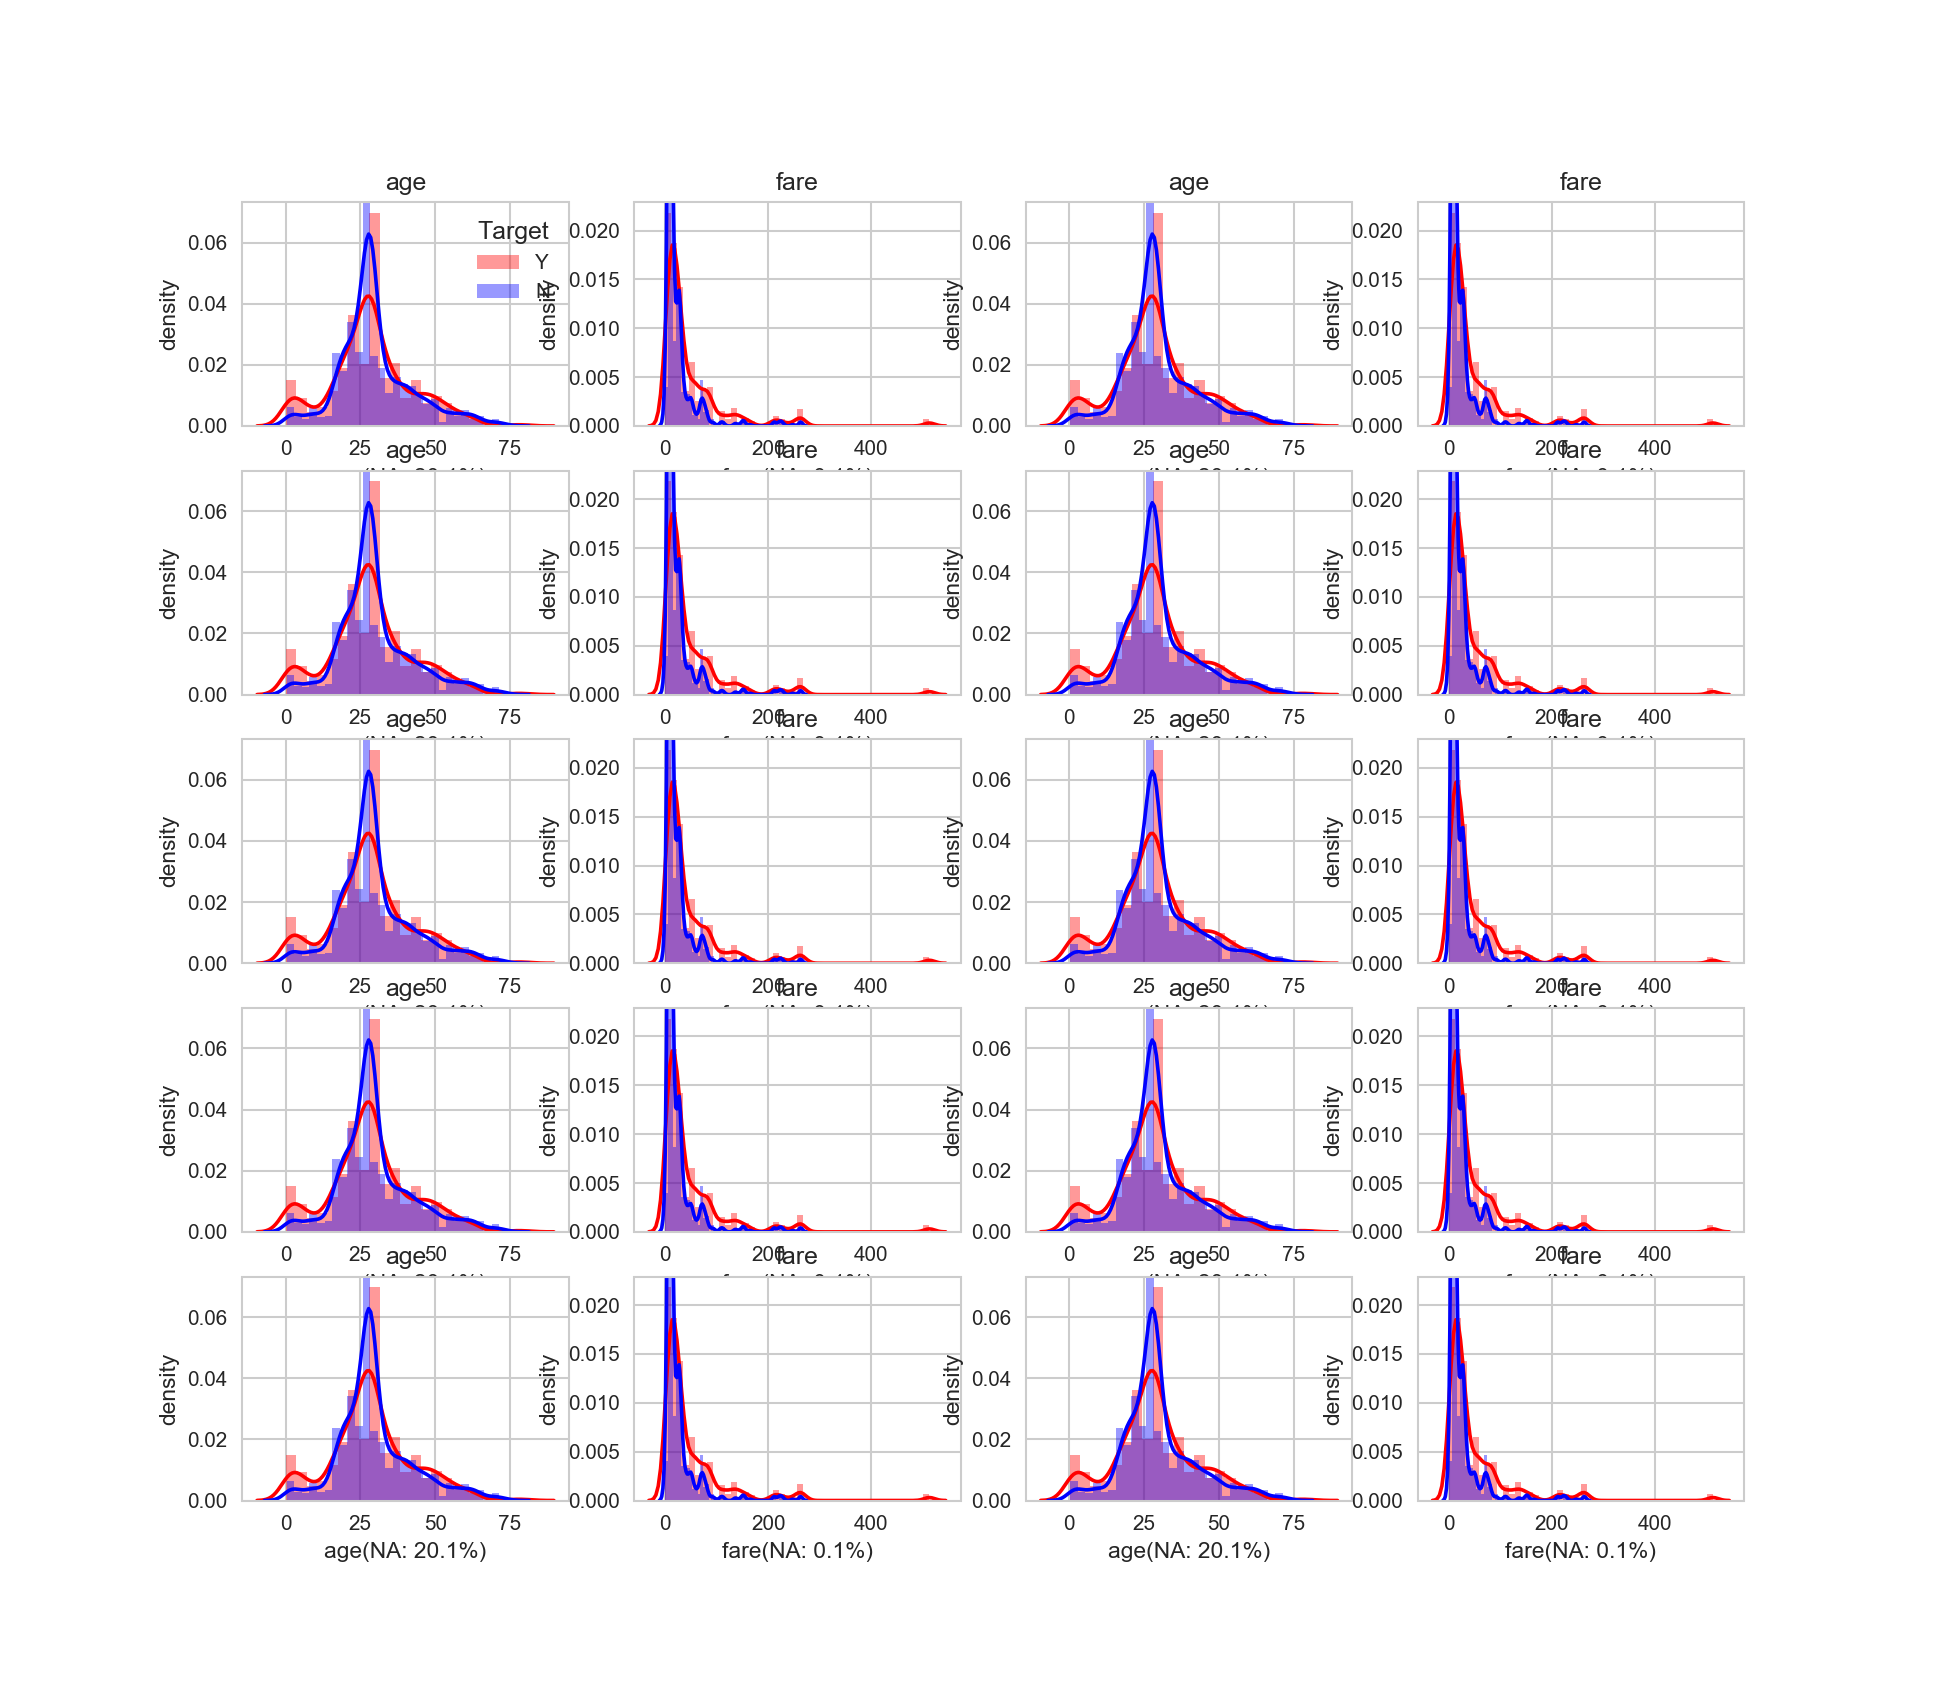

In [16]:
#plt.figure()
metr = ["age","fare"]*10
fig, ax = plt.subplots(5,4)
for i in range(len(metr)):
    axact = ax.flat[i]
    sns.distplot(df.loc[df.target == "Y", metr[i]], color = "red", label = "Y", ax = axact)
    sns.distplot(df.loc[df.target == "N", metr[i]], color = "blue", label = "N", ax = axact)
    axact.set_title(metr[i])
    axact.set_ylabel("density")
    axact.set_xlabel(metr[i] + "(NA: " + str(round(misspct[metr[i]] * 100, 1)) + "%)")
ax[0,0].legend(title = "Target", loc = "best")
#plt.subplot_tool()